### Cell 0
Ładowanie bibliotek do obróbki danych, wizualizacji, metryk oraz budowy i trenowania obwodu kwantowego w Qiskit.

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import time
import os

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score

# Qiskit Imports
from qiskit import QuantumCircuit
from qiskit.circuit.library import RealAmplitudes, ZFeatureMap
from qiskit_algorithms.optimizers import COBYLA, ADAM, SPSA
from qiskit_machine_learning.neural_networks import SamplerQNN

np.random.seed(0)

### Cell 1
Konfiguracja danych - definiowanie które rekordy / pacjenci należą do zbioru treningowego oraz testowego, wycięcie okna wokół uderzenia oraz jakie symbole uznawane są za normę lub anomalię.

In [37]:
TRAIN_PATIENTS = ['100', '101', '102']
TEST_PATIENTS = ['106', '119']

SAMPLES_BEFORE = 30
SAMPLES_AFTER = 60
WINDOW_SIZE = SAMPLES_BEFORE + SAMPLES_AFTER

# Cechy PCA - tyle kubitów
N_DIM = 8
LIMIT_PER_PATIENT = 600

NORMAL_SYMBOLS = ['N', 'L', 'R', 'e', 'j']
ANOMALY_SYMBOLS = ['V', 'A', 'a', 'J', 'S', 'F', '!', 'E', '/']

### Cell 2
Ładowanie danych pacjenta: wczytywanie sygnału, adnotacje i wycinanie okna. 
Loader bierze pacjenta -> czyta CSV sygnału i CSV adnotacji -> wycina okna wcześniej określonej długości wokół wskazanych indeksów -> dzieli na listę okien normalnych oraz anomalii.

In [38]:
def load_patient_data(patient_id):
    # Wczytuje sygnał i wycina uderzenia na podstawie adnotacji
    ekg_file = f'archive/{patient_id}_ekg.csv'
    ann_file = f'archive/{patient_id}_annotations_1.csv'
    
    if not os.path.exists(ekg_file) or not os.path.exists(ann_file):
        print('nie ma pliku')
        return [], []
    
    # wczytywanie sygnału ekg dla pacjenta, szukam po tej kolumnie MLII
    df_ekg = pd.read_csv(ekg_file)
    # Usuwamy spacje z nazw kolumn (częsty błąd w CSV)
    df_ekg.columns = df_ekg.columns.str.strip()
    
    try:
        if 'MLII' in df_ekg.columns:
            signal = df_ekg['MLII'].values
        elif 'V5' in df_ekg.columns:
            signal = df_ekg['V5'].values
        else:
            # Jeśli nie ma nazw, bierzemy kolumnę indeks 1 (bo 0 to zazwyczaj czas/sample)
            signal = df_ekg.iloc[:, 1].values
    except Exception as e:
        print(f'error {e}')
        return [], []
    
    den = np.max(signal) - np.min(signal)
    if den == 0:
        return [], []
    signal = (signal - np.min(signal)) / den
    
    try:
        df_ann = pd.read_csv(ann_file)
        df_ann.columns = df_ann.columns.str.strip() # Czyścimy nazwy
            
        # Szukamy odpowiednich kolumn (sample = pozycja, symbol = typ)
        # Czasami nazywają się 'sample', 'Sample', 'time', etc.
        sample_col = next((c for c in df_ann.columns if 'index' in c.lower()), None)
        symbol_col = next((c for c in df_ann.columns if 'annotation_symbol' in c.lower()), None)
        
        if not sample_col or not symbol_col:
            print("  Nie znaleziono kolumn 'sample' lub 'symbol' w adnotacjach.")
            return [], []
        
        peaks = df_ann[sample_col].values
        symbols = df_ann[symbol_col].values
    except Exception as e:
        print(f'blad {e}')
        return [], []
    
    beats_normal = []
    beats_anomaly = []
    
    for p, sym in zip(peaks, symbols):
        # Pomijamy uderzenia na samym początku lub końcu nagrania
        if p - SAMPLES_BEFORE < 0 or p + SAMPLES_AFTER > len(signal):
            continue
            
        # Wycinek
        window = signal[p - SAMPLES_BEFORE : p + SAMPLES_AFTER]
        
        # Upewniamy się, że długość jest idealna
        if len(window) != WINDOW_SIZE:
            continue

        # Klasyfikacja
        if sym in NORMAL_SYMBOLS:
            if len(beats_normal) < LIMIT_PER_PATIENT:
                beats_normal.append(window)
        elif sym in ANOMALY_SYMBOLS:
            if len(beats_anomaly) < LIMIT_PER_PATIENT:
                beats_anomaly.append(window)
                
    print(f"  -> Znaleziono: {len(beats_normal)} Normal, {len(beats_anomaly)} Anomaly")
    return beats_normal, beats_anomaly

### Cell 3
Zbieranie danych, PCA, skalowanie, zapis, wykresy kontrolne.
Przebieg pipeline'u polega na wczytaniu uderzeń dla pacjentów, zebraniu train/test, PCA (tylko na dancyh train normal), MinMaxScaler (), zapisanie gotowych macierzy do .npy oraz rysowanie wykresów kontrolnych.

>>> KROK 1: Wczytywanie danych treningowych (Zdrowi)...
  -> Znaleziono: 600 Normal, 34 Anomaly
  -> Znaleziono: 600 Normal, 3 Anomaly
  -> Znaleziono: 99 Normal, 600 Anomaly

>>> KROK 2: Wczytywanie danych testowych (Mieszane)...
  -> Znaleziono: 600 Normal, 520 Anomaly
  -> Znaleziono: 600 Normal, 444 Anomaly

STATUS DANYCH SUROWYCH:
Wymiar pojedynczego uderzenia: 90 próbek
Liczba próbek Train (Normal): 1299
Liczba próbek Test (Normal): 1200
Liczba próbek Test (Anomaly): 964

>>> KROK 3: Redukcja wymiaru (PCA) z 90 do 8...
Wyjaśniona wariancja (ile info zachowaliśmy): 99.48%
>>> KROK 4: Skalowanie do zakresu (0, pi)...
Zapisano PCA i scaler do pliku: preprocessing_8dim.joblib

>>> KROK 5: Zapisywanie plików .npy...
GOTOWE! Możesz teraz uruchomić skrypt z Qiskit.

>>> Generowanie wykresu kontrolnego...


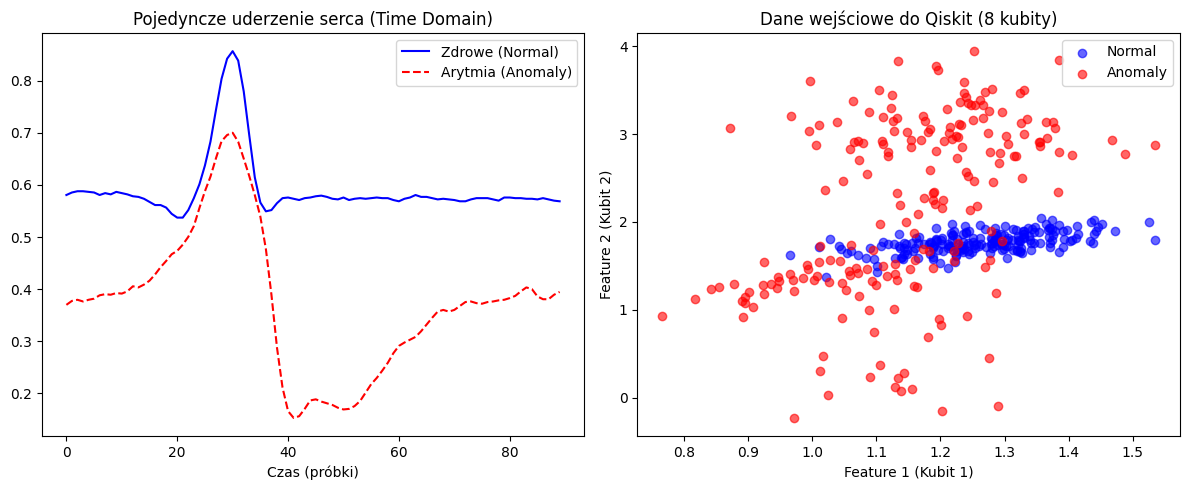

In [39]:
# --- ZBIERANIE DANYCH ---
all_train_normal = []
all_test_normal = []
all_test_anomaly = []

print(">>> KROK 1: Wczytywanie danych treningowych (Zdrowi)...")
for pid in TRAIN_PATIENTS:
    n, _ = load_patient_data(pid)
    all_train_normal.extend(n)

print("\n>>> KROK 2: Wczytywanie danych testowych (Mieszane)...")
for pid in TEST_PATIENTS:
    n, a = load_patient_data(pid)
    all_test_normal.extend(n)
    all_test_anomaly.extend(a)

# Konwersja na numpy array
X_train = np.array(all_train_normal)
X_test_normal = np.array(all_test_normal)
X_test_anomaly = np.array(all_test_anomaly)

print(f"\nSTATUS DANYCH SUROWYCH:")
print(f"Wymiar pojedynczego uderzenia: {WINDOW_SIZE} próbek")
print(f"Liczba próbek Train (Normal): {X_train.shape[0]}")
print(f"Liczba próbek Test (Normal): {X_test_normal.shape[0]}")
print(f"Liczba próbek Test (Anomaly): {X_test_anomaly.shape[0]}")

if len(X_train) == 0:
    print("BŁĄD KRYTYCZNY: Brak danych treningowych. Sprawdź nazwy plików CSV!")
    raise ValueError

# --- PRZETWARZANIE (PCA) ---
print(f"\n>>> KROK 3: Redukcja wymiaru (PCA) z {WINDOW_SIZE} do {N_DIM}...")

# 1. Trenujemy PCA tylko na zdrowych danych treningowych
pca = PCA(n_components=N_DIM)
pca.fit(X_train)

# 2. Transformujemy wszystkie zbiory
X_train_pca = pca.transform(X_train)
X_test_normal_pca = pca.transform(X_test_normal)

# Obsługa przypadku, gdyby nie było anomalii (żeby kod nie padł)
if len(X_test_anomaly) > 0:
    X_test_anomaly_pca = pca.transform(X_test_anomaly)
else:
    X_test_anomaly_pca = np.empty((0, N_DIM))

print(f"Wyjaśniona wariancja (ile info zachowaliśmy): {sum(pca.explained_variance_ratio_):.2%}")

# --- SKALOWANIE DO KOMPUTERA KWANTOWEGO ---
# Qiskit lubi dane w zakresie (0, pi) lub (-1, 1). 
# Użyjemy (0, pi) pod bramki rotacji.
print(">>> KROK 4: Skalowanie do zakresu (0, pi)...")

scaler = MinMaxScaler(feature_range=(0, np.pi))
scaler.fit(X_train_pca) # Uczymy skaler na treningu

joblib.dump(
    {
    "pca": pca,
    "scaler": scaler,
    "n_dim": N_DIM,
    "window_size": WINDOW_SIZE
    },
    "preprocessing_8dim.joblib"
)
print("Zapisano PCA i scaler do pliku: preprocessing_8dim.joblib")

X_train_final = scaler.transform(X_train_pca)
X_test_normal_final = scaler.transform(X_test_normal_pca)

if len(X_test_anomaly) > 0:
    X_test_anomaly_final = scaler.transform(X_test_anomaly_pca)
else:
    X_test_anomaly_final = X_test_anomaly_pca

# --- ZAPISYWANIE ---
print("\n>>> KROK 5: Zapisywanie plików .npy...")
np.save('train_data.npy', X_train_final)
np.save('test_normal.npy', X_test_normal_final)
np.save('test_anomaly.npy', X_test_anomaly_final)
print("GOTOWE! Możesz teraz uruchomić skrypt z Qiskit.")

# --- WIZUALIZACJA ---
print("\n>>> Generowanie wykresu kontrolnego...")
plt.figure(figsize=(12, 5))

# Wykres 1: Jak wygląda surowe uderzenie?
plt.subplot(1, 2, 1)
plt.plot(X_train[0], label='Zdrowe (Normal)', color='blue')
if len(X_test_anomaly) > 0:
    plt.plot(X_test_anomaly[0], label='Arytmia (Anomaly)', color='red', linestyle='--')
plt.title("Pojedyncze uderzenie serca (Time Domain)")
plt.xlabel("Czas (próbki)")
plt.legend()

# Wykres 2: Jak to wygląda po PCA?
plt.subplot(1, 2, 2)
# Rysujemy tylko po 100 kropek żeby było czytelnie
plt.scatter(X_test_normal_final[:200, 0], X_test_normal_final[:200, 1], 
            c='blue', alpha=0.6, label='Normal')
if len(X_test_anomaly_final) > 0:
    plt.scatter(X_test_anomaly_final[:200, 0], X_test_anomaly_final[:200, 1], 
                c='red', alpha=0.6, label='Anomaly')
plt.title(f"Dane wejściowe do Qiskit ({N_DIM} kubity)")
plt.xlabel("Feature 1 (Kubit 1)")
plt.ylabel("Feature 2 (Kubit 2)")
plt.legend()

plt.tight_layout()
plt.show()

### Cell 4
Budowa QNN, trening, scoring, wykresy.
- Wczytanie plików .npy z przygotowanymi cechami.
- Budowa obwodu: feature_map + ansatz.
- Tworzenie SamplerQNN.
- Definiowanie optymalizatora - uczenie parametrów ansaztu.
- Obliczenie s_norm, s_anom - ewaluacja modelu.
- Przedstawienie wykresów loss i histogramów wyników.

C:\Users\Marcelius\AppData\Local\Temp\ipykernel_17520\4217744909.py:25: DeprecationWarning: The class ``qiskit.circuit.library.data_preparation._z_feature_map.ZFeatureMap`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use the z_feature_map function as a replacement. Note that this will no longer return a BlueprintCircuit, but just a plain QuantumCircuit.
  feature_map = ZFeatureMap(feature_dimension=INPUT_DIM, reps=1)
C:\Users\Marcelius\AppData\Local\Temp\ipykernel_17520\4217744909.py:26: DeprecationWarning: The class ``qiskit.circuit.library.n_local.real_amplitudes.RealAmplitudes`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use the function qiskit.circuit.library.real_amplitudes instead.
  ansatz = RealAmplitudes(num_qubits=INPUT_DIM, reps=2, entanglement='linear')
No gradient function provided, creating a gradient function. If your Sampler requires transpilation, please provide a pass manager.


>>> 1. Wczytywanie danych (8 cech)...
    Trening na: 1299 próbkach
>>> 2. Budowanie obwodu (8 kubitów)...
>>> 3. Start treningu (Optimizer: SPSA, Iter: 100)...
    Eval 10: Koszt = 0.5032
    Eval 20: Koszt = 0.3282
    Eval 30: Koszt = 0.5114
    Eval 40: Koszt = 0.5273
    Eval 50: Koszt = 0.5478
    Eval 60: Koszt = 0.2627
    Eval 70: Koszt = 0.2330
    Eval 80: Koszt = 0.0894
    Eval 90: Koszt = 0.2054
    Eval 100: Koszt = 0.1328
    Eval 110: Koszt = 0.1384
    Eval 120: Koszt = 0.1206
    Eval 130: Koszt = 0.0725
    Eval 140: Koszt = 0.1161
    Eval 150: Koszt = 0.0788
    Eval 160: Koszt = 0.1192
    Eval 170: Koszt = 0.0725
    Eval 180: Koszt = 0.0841
    Eval 190: Koszt = 0.0816
    Eval 200: Koszt = 0.0741
    Eval 210: Koszt = 0.1043
    Eval 220: Koszt = 0.0471
    Eval 230: Koszt = 0.0716
    Eval 240: Koszt = 0.0827
    Eval 250: Koszt = 0.0875
>>> Czas treningu: 107.0 s
>>> Wyniki optymalizacji: fun=0.051803
>>> 4. Generowanie wyników...


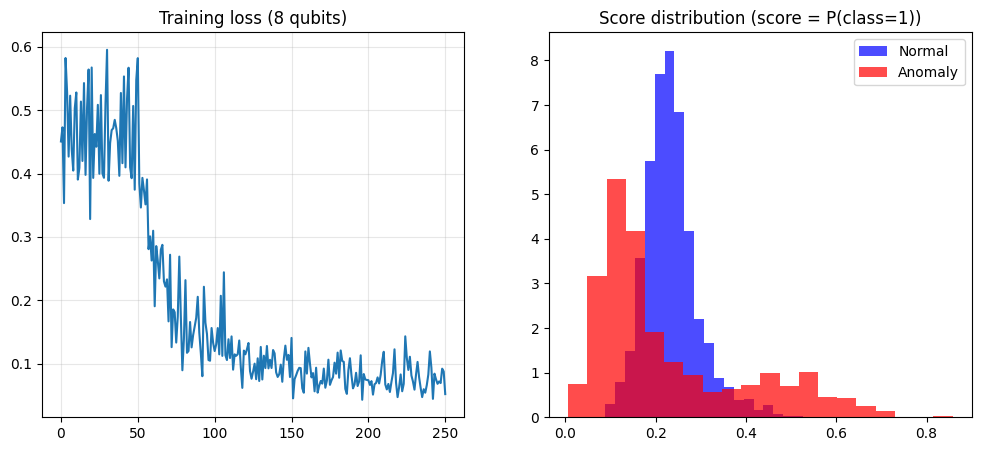

In [45]:
INPUT_DIM = N_DIM     # Teraz mamy 8 cech
MAX_ITER = 100     # Dajmy mu trochę czasu
BATCH_SIZE = 25
EVAL_BATCH = 50 

print(f">>> 1. Wczytywanie danych (8 cech)...")
try:
    train_data = np.load('train_data.npy')
    test_normal = np.load('test_normal.npy')
    test_anomaly = np.load('test_anomaly.npy')
except FileNotFoundError as e:
    raise FileNotFoundError("BŁĄD: Nie znaleziono plików. Uruchom najpierw prepare_data.py z N_DIM=8!") from e

if train_data.ndim != 2:
    raise ValueError(f"""BŁĄD: train_data ma wymiar: {train_data.ndim}, 
                     oczekiwano macierzy 2D (n_samples, n_fueatures).""")
if train_data.shape[1] != INPUT_DIM:
    raise ValueError(f"""BŁĄD: Dane mają wymair: {train_data.shape[1]},
                     a kod oczekuje {INPUT_DIM}.""")

print(f"    Trening na: {len(train_data)} próbkach")

# --- OBWÓD KWANTOWY ---
print(f">>> 2. Budowanie obwodu ({INPUT_DIM} kubitów)...")
feature_map = ZFeatureMap(feature_dimension=INPUT_DIM, reps=1)
ansatz = RealAmplitudes(num_qubits=INPUT_DIM, reps=2, entanglement='linear')

qc = QuantumCircuit(INPUT_DIM)
qc.append(feature_map, range(INPUT_DIM))
qc.append(ansatz, range(INPUT_DIM))

def parity(x: int) -> int:
    return x % 2

qnn = SamplerQNN(
    circuit=qc,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
    interpret=parity,
    output_shape=2
)

# --- TRENING ---
objective_func_vals = []

def cost_func(params_values):
    BS = min(BATCH_SIZE, len(train_data))
    batch_idx = np.random.choice(len(train_data), BS, replace=False)
    batch_data = train_data[batch_idx]
    
    probs = qnn.forward(batch_data, params_values) # shape (BS, 2)
    p1 = np.clip(probs[:, 1], 1e-4, 1.0 - 1e-4)
    loss = float(np.mean(p1))
    
    objective_func_vals.append(loss)
    if len(objective_func_vals) % 10 == 0:
        print(f"    Eval {len(objective_func_vals)}: Koszt = {loss:.4f}")
    return loss

print(f">>> 3. Start treningu (Optimizer: SPSA, Iter: {MAX_ITER})...")

# --- ZMIANA TUTAJ ---
# COBYLA wyrzucamy:
# optimizer = COBYLA(maxiter=MAX_ITER) 

# Wstawiamy ADAM. 
# lr=0.01 to "learning rate". Jak wykres skacze jak szalony, zmniejsz do 0.001.
#optimizer = ADAM(maxiter=MAX_ITER, lr=0.01) 
optimizer = SPSA(maxiter=MAX_ITER)
initial_weights = 0.1 * (2 * np.random.random(ansatz.num_parameters) - 1)

start_t = time.time()
# ADAM wymaga gradientów, ale Qiskit SamplerQNN policzy je sobie sam (metodą różnic skończonych)
result = optimizer.minimize(fun=cost_func, x0=initial_weights)
print(f">>> Czas treningu: {time.time() - start_t:.1f} s")
print(f">>> Wyniki optymalizacji: fun={result.fun:.6f}")

# --- WYNIKI ---
print(">>> 4. Generowanie wyników...")
trained_weights = result.x

# Funkcja do ewaluacji (z batchem)
def get_scores_anomaly_prob(data):
    """ 
    Zwraca score = p1 (prawdopodobieństwo klasy 1 = 'anomaly' wg interpretacji QNN). 
    Jeśli etykietowanie jest odwrotne - zmienić na p[:, 0]
    """
    scores = []
    for i in range(0, len(data), EVAL_BATCH): # Mniejsze paczki dla 8 kubitów
        batch = data[i:i+EVAL_BATCH]
        p = qnn.forward(batch, trained_weights)
        p1 = p[:, 1]
        scores.extend(p1.tolist())
    return np.array(scores, dtype=float)

s_norm = get_scores_anomaly_prob(test_normal)
s_anom = get_scores_anomaly_prob(test_anomaly)

# --- WIZUALIZACJA ---
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(objective_func_vals)
plt.title(f"Training loss ({INPUT_DIM} qubits)")
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(s_norm, bins=20, alpha=0.7, color='Blue', label='Normal', density=True)
plt.hist(s_anom, bins=20, alpha=0.7, color='Red', label='Anomaly', density=True)
plt.title("Score distribution (score = P(class=1))")
plt.legend()

plt.savefig("results_8qubits.png")
plt.show()

In [41]:
scores = np.concatenate([s_norm, s_anom])
y_true = np.array([0]*len(s_norm) + [1]*len(s_anom))

def best_threshold(rule="greater"):
    # rule="greater": anomaly jeśli score > t
    # rule="less": anomaly jeśli score < t
    ts = np.quantile(scores, np.linspace(0.01, 0.99, 200))
    best = (-1, None)
    for t in ts:
        if rule == "greater":
            y_pred = (scores > t).astype(int)
        else:
            y_pred = (scores < t).astype(int)
        acc = accuracy_score(y_true, y_pred)
        if acc > best[0]:
            best = (acc, t)
    return best

acc_g, t_g = best_threshold("greater")
acc_l, t_l = best_threshold("less")

print("Best rule score > t:", acc_g, "t =", t_g)
print("Best rule score < t:", acc_l, "t =", t_l)

print("Means:", "mean_norm=", np.mean(s_norm), "mean_anom=", np.mean(s_anom))


Best rule score > t: 0.6437153419593346 t = 0.44391498865377355
Best rule score < t: 0.6890018484288355 t = 0.18199430396402067
Means: mean_norm= 0.25873370285709674 mean_anom= 0.2828682450138584


### Cell 5
Macierz pomyłek + metryki


>>> Generowanie Macierzy Pomyłek...
--- WYNIKI DLA PROGU 0.18 ---
Dokładność (Accuracy): 80.08%
Precyzja (Precision):  76.00% (Ile z wykrytych arytmii to faktycznie arytmie?)
Czułość (Recall):      80.81% (Ile z prawdziwych arytmii udało się wykryć?)


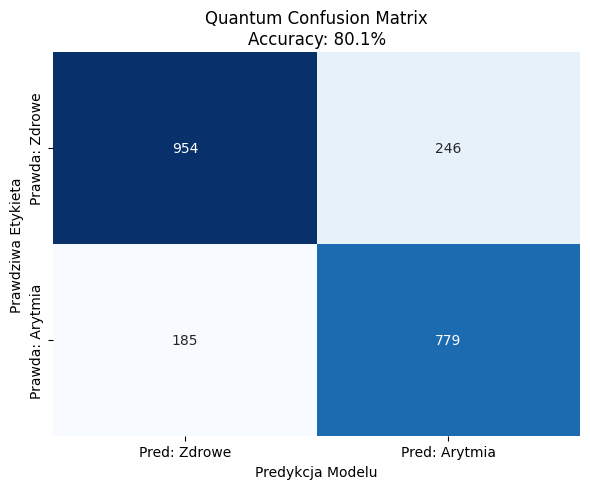

In [48]:
# =============================================
# DODATEK: WIZUALIZACJA MACIERZY POMYŁEK
# =============================================

print("\n>>> Generowanie Macierzy Pomyłek...")

# 1. USTAWIENIE PROGU (THRESHOLD)
# Patrząc na Twój ostatni histogram, idealne przecięcie jest w okolicy 0.14.
# Wszystko poniżej 0.14 traktujemy jako jedną klasę, powyżej jako drugą.
THRESHOLD = 0.18
THRESHOLD2 = 0.35

# 2. PRZYGOTOWANIE ETYKIET PRAWDZIWYCH (Ground Truth)
# 0 = Zdrowe (Normal), 1 = Arytmia (Anomaly)
y_true = [0] * len(s_norm) + [1] * len(s_anom)

# 3. PRZYGOTOWANIE PREDYKCJI MODELU (Z uwzględnieniem INWERSJI!)
# WAŻNE: W Twoim wyniku arytmia (czerwone) ma MAŁY błąd, a zdrowe DUŻY.
# Musimy odwrócić logikę:
# Jeśli wynik < THRESHOLD -> To jest Arytmia (Klasa 1)
# Jeśli wynik > THRESHOLD -> To jest Zdrowe (Klasa 0)

y_pred = []
# Oceniamy zdrowe
for score in s_norm:
    prediction = 1 if (score < THRESHOLD or score > THRESHOLD2) else 0
    y_pred.append(prediction)

# Oceniamy chore
for score in s_anom:
    prediction = 1 if (score < THRESHOLD or score > THRESHOLD2) else 0
    y_pred.append(prediction)

# 4. OBLICZENIE METRYK
cm = confusion_matrix(y_true, y_pred)
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec = recall_score(y_true, y_pred)

print(f"--- WYNIKI DLA PROGU {THRESHOLD} ---")
print(f"Dokładność (Accuracy): {acc:.2%}")
print(f"Precyzja (Precision):  {prec:.2%} (Ile z wykrytych arytmii to faktycznie arytmie?)")
print(f"Czułość (Recall):      {rec:.2%} (Ile z prawdziwych arytmii udało się wykryć?)")

# 5. RYSOWANIE ŁADNEJ MACIERZY (Seaborn Heatmap)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Pred: Zdrowe', 'Pred: Arytmia'],
            yticklabels=['Prawda: Zdrowe', 'Prawda: Arytmia'])
plt.title(f'Quantum Confusion Matrix\nAccuracy: {acc:.1%}')
plt.ylabel('Prawdziwa Etykieta')
plt.xlabel('Predykcja Modelu')
plt.tight_layout()
plt.savefig("confusion_matrix.png")
# plt.show() # Zakomentowane, bo show() będzie na końcu głównego skryptu